In [46]:
#Some test to exxtract stanford dataset
#!pip install dash-leaflet
#!pip install obspy
#!pip install dash-extensions
#!pip install librosa
#!pip install dash-bootstrap-components
#!pip install geopy

In [47]:
#Statistics layer: heatmap by geographic regions, heatmap by countries
# Global regions: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/CQWUBI

In [48]:
#!pip install dash-extensions==0.0.65

In [49]:
import pandas as pd
import numpy as np
import obspy
#import h5py
from obspy import UTCDateTime
import numpy as np
from obspy.clients.fdsn.client import Client
import matplotlib.pyplot as pl

#df_test = pd.read_csv("csvs/chunk5.csv")
df_test = pd.read_csv("csvs/earthquake_metadata.csv",low_memory=False)

df_test.set_index('trace_name',inplace= True)

In [50]:
#df_test['station_id'] = df_test['network_code'] + '_' + df_test['receiver_code']
#df_test.to_csv("csvs/earthquake_metadata.csv")


In [51]:
from obspy.clients.fdsn.header import URL_MAPPINGS

In [52]:
provider_list = sorted(URL_MAPPINGS.keys())

In [53]:
df_test = df_test.dropna(subset=['source_distance_km', 'source_latitude','source_longitude'])

In [54]:
df_test = df_test[df_test['trace_category'] == 'earthquake_local']


In [55]:
min(df_test['source_distance_km'])

df_test_closest = df_test[df_test['source_distance_km'] == min(df_test['source_distance_km'])]

## Amplitude normalization init test

In [56]:
 

import librosa
import soundfile as sf
#Extract the proper seismic instrument
#index: 0: north-south, 1: east-west, 2:vertical
def create_seismic_sound_to_dash_bytes(x):
    #print('Read')
    x1 = x.data
    #print('Normalize')
    norm_x =  x1/x1.std()
    #print('Resample')
    #norm_x_resampled = norm_x.resample(8000)
    norm_x_resampled = librosa.resample(norm_x, x.stats.sampling_rate, 8000)
    #print('Export')
    out_audio = BytesIO()
    #norm_x_resampled = librosa.resample(norm_x, 100, 8000)
    sf.write(out_audio,norm_x_resampled,8000,format = 'wav')

    #import base64 
    #encoded=base64.b64encode(open("file.wav").read())
    

    #encoded=base64.b64encode(norm_x_resampled).decode("ascii").replace("\n", "")
    out_audio.seek(0)
    encoded=base64.b64encode(out_audio.read()).decode("ascii").replace("\n", "")
    
    #encoded.see
    

    #print(encoded)

    return "data:audio/wav;base64,{}".format(encoded)

    #return out_audio

Build up velocity
https://docs.obspy.org/contents.html

Compression, amplitude normalization:
https://librosa.org/doc/main/generated/librosa.effects.time_stretch.html
https://superkogito.github.io/blog/rmsnormalization.html

https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.remove_response.html

https://docs.obspy.org/tutorial/code_snippets/filtering_seismograms.html

In [57]:
from io import BytesIO
import base64
def fig_to_uri(in_fig, close_all=True, **save_args):
    # type: (plt.Figure) -> str
    """
    Save a figure as a URI
    :param in_fig:
    :return:
    """
    out_img = BytesIO()
    in_fig.savefig(out_img, format='png', **save_args)
    if close_all:
        in_fig.clf()
        plt.close('all')
    out_img.seek(0)  # rewind file
    encoded = base64.b64encode(out_img.read()).decode("ascii").replace("\n", "")
    #return encoded
    return "data:image/png;base64,{}".format(encoded)

In [58]:
from io import BytesIO
import base64
from scipy import signal
def spectrogram_to_uri(input_data, close_all=True, **save_args):    
    #todo: maybe we might be able to make a bytewriter approach, which is easier, and can be used for seismic plot and spectrograms at once
    
    f, t, Sxx = signal.spectrogram(input_data.filter("highpass", freq=0.5).data, input_data.stats.sampling_rate)
    plt.pcolormesh(t, f, np.log10(Sxx))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')


    # type: (plt.Figure) -> str
    """
    Save a figure as a URI
    :param in_fig:
    :return:
    """
    out_img = BytesIO()
    plt.savefig(out_img, format='png', **save_args)
    if close_all:
        plt.clf()
        plt.close('all')
    out_img.seek(0)  # rewind file
    encoded = base64.b64encode(out_img.read()).decode("ascii").replace("\n", "")
    #return encoded
    return "data:image/png;base64,{}".format(encoded)

In [59]:
import matplotlib.pyplot as plt

In [60]:
df_test['time'] = pd.to_datetime(df_test['trace_start_time'], infer_datetime_format=True)
df_test['source_depth_km'] = pd.to_numeric(df_test['source_depth_km'],errors='coerce')
df_test['source_magnitude'] = pd.to_numeric(df_test['source_magnitude'],errors='coerce')
#df_test['source_magnitude'].sort_values()
#df_test.head(2)

In [61]:
def extract_waveform(client, event_record):
    #print(event_record)
    #print(event_record['network_code'])
    #print(event_record['receiver_code'])
    #print(UTCDateTime(event_record['time']))

    wave = client.get_waveforms(network=event_record['network_code'],
                            station=event_record['receiver_code'],
                            starttime=UTCDateTime(event_record['time']),
                                endtime=UTCDateTime(event_record['time']) + 60,
                                location = "*",
                                channel = "*")

    
    #temprorarily extract only one stream
    return wave[0]

In [62]:
#stations_df = pd.read_csv('stations_duplicates_removed.csv')
stations_df = pd.read_csv('csvs/stations_definition.csv')
stations_df['station_opened'] =  pd.to_datetime(stations_df['station_opened'], infer_datetime_format=True)

#df_test
#stations_df = stations_df
#stations_df[
stations_df = stations_df[stations_df['station_id'].isin(stations)]
stations_df.to_csv('csvs/stations_definition.csv',index = False)

In [63]:
selected_event = df_test.loc['KAN08.GS_20150408005359_EV']

provider_of_waveform = stations_df[(stations_df['network_name'] == selected_event['network_code']) &  (stations_df['station_name'] == selected_event['receiver_code'])]
clien = provider_of_waveform['provider'].tolist()[0]

In [64]:
clien = Client(clien)
wave_test = extract_waveform(clien, selected_event)

C:\Users\Andras\anaconda3\envs\interdisciplinary_leaflet\lib\site-packages\ipykernel_launcher.py:12: FutureWarning:

Pass orig_sr=200.0, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error

C:\Users\Andras\anaconda3\envs\interdisciplinary_leaflet\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



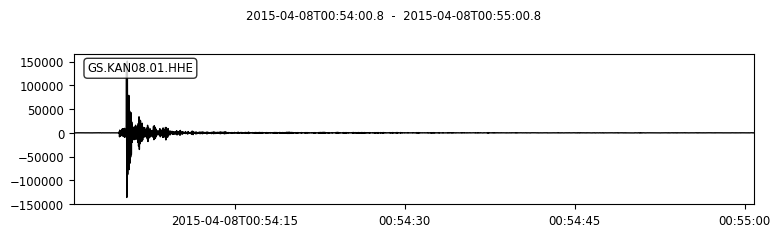

In [65]:
o_file = create_seismic_sound_to_dash_bytes(wave_test)
spectrogram_plot = spectrogram_to_uri(wave_test)

base_seismogram = fig_to_uri(wave_test.plot())

In [66]:
#df_test = df_test[['time','source_depth_km','source_magnitude','trace_name','source_latitude','source_longitude','trace_category']]
#df_test = df_test[['time','source_depth_km','source_magnitude','source_latitude','source_longitude','trace_category']]

In [67]:
info_colnames = ['trace_name','location','latitude','longitude','event_recorded_at','earthquake_depth','earthquake_magnitude']
#info_colnames = ['trace_name','latitude','longitude','event_recorded_at','earthquake_depth','earthquake_magnitude']
def create_event_infos(x):
    #'time','source_depth_km','source_magnitude','trace_name','source_latitude','source_longitude','trace_category'
    #selected_record = df_test.loc[x['trace_name']]
    selected_record = df_test.loc[x]
    latitude = str(selected_record['source_latitude'])
    longitude = str(selected_record['source_longitude'])
    address_details = ['road','county','state', 'country']
    try:
        location = geolocator.reverse(latitude + "," + longitude, language='en').raw
        location_string = str()
        for a in address_details:
            try:
                location_string += location['address'][a]
                location_string += ', '

            except KeyError:
                pass
        
        location_string = location_string[:-2]
    except AttributeError:
        location_string = "N/A"


    #print(location)
    info_dict = dict()
    info_dict['trace_name'] = x
    info_dict['location'] = location_string
    info_dict['latitude'] = latitude
    info_dict['longitude'] = longitude
    info_dict['event_recorded_at'] = str(selected_record['time'])
    info_dict['earthquake_depth'] = f'{selected_record["source_depth_km"]} km'
    info_dict['earthquake_magnitude'] = f'{selected_record["source_magnitude"]} km'

    return pd.DataFrame.from_dict(info_dict, orient='index').reset_index().to_dict('records')
    

selected_event = create_event_infos('HPC.NC_20130403221010_EV')
selected_event

df_test.head(5).to_dict('records')

Extract the minimum depth, magnitude, recording times etcc

In [68]:
#Latitudes and longitudes
site_lat = df_test.source_latitude
site_lon = df_test.source_longitude
hover_desc = 'Timestamp: ' +  str(df_test.time) + '<br>Category: ' + df_test.trace_category
#hover_desc = f'Time of registration: {df_earthquake_detections.trace_start_time} <br> Category: {df_earthquake_detections.trace_category}'
#time = df_earthquake_detections.trace_start_time
#ctg =df_earthquake_detections.trace_category
#locations_name = df.text
#min timestamp
#Extract timestamp range
min_date = min(df_test['time']).date()
max_date = max(df_test['time']).date()
#Extract minimum and maximum depth
min_depth = min(df_test['source_depth_km'])
max_depth = max(df_test['source_depth_km'])
#Extract minimum and maximum magnitude
min_magnitude = min(df_test['source_magnitude'])
max_magnitude = max(df_test['source_magnitude'])

depth_space = np.linspace(start=min_depth,stop=max_depth,num=8,endpoint=True,dtype=np.float64)
magnitude_space = np.linspace(start=min_magnitude,stop=max_magnitude,num=8,endpoint=True,dtype=np.float64)

In [69]:
#stations_df = pd.read_csv('station_definitions_from_metadata.csv')
#stations_df = pd.read_csv('stations_duplicates_removed.csv')

#stations_df.drop(columns = 'Unnamed: 0',inplace = True)

In [70]:
import dash_leaflet.express as dlx  
def stations_df_to_geojson(x):
    #df_points = x[['trace_name','source_latitude','source_longitude']]    
    df_points = x.groupby(['station_id','network_name','station_name','latitude','longitude','station_opened','station_closed'], dropna=False)['provider'].apply(list).reset_index()
    df_points_records_renamed = df_points.rename(columns = {'latitude' :'lat','longitude' :'lon'}).to_dict('records')
    return dlx.dicts_to_geojson(df_points_records_renamed)


In [71]:
provider_list = stations_df['provider'].value_counts().index.tolist()

In [72]:
#stations_geojson = stations_df_to_geojson(stations_df.head(10))
stations_geojson = stations_df_to_geojson(stations_df)

In [73]:

def dataframe_to_geojson(x):
    df_points = x.reset_index()[['trace_name','source_latitude','source_longitude','source_magnitude']]
    df_points_records_renamed = df_points.rename(columns = {'source_latitude' :'lat','source_longitude' :'lon'}).to_dict('records')
    return dlx.dicts_to_geojson(df_points_records_renamed)


In [74]:
#df_points = df_test.reset_index()[['trace_name','time','source_depth_km','source_magnitude','source_latitude','source_longitude']]
df_points = df_test.reset_index()[['trace_name','source_latitude','source_longitude','source_magnitude']]
#df_points = df_test.head(20).reset_index()[['trace_name','source_latitude','source_longitude','source_magnitude']]
#df_points.rename(columns={'trace_name':'name'})
#.head(30)
#df_points_records_renamed = df_points.rename(columns = {'source_latitude' :'lat','source_longitude' :'lon'}).to_dict('records')

In [75]:


#data_points_geojson = dlx.dicts_to_geojson(df_points_records_renamed) 
data_points_geojson = dataframe_to_geojson(df_points) 

df_test = df_test[df_test['trace_category'] == 'earthquake_local']

df_test = df_test[df_test['station_id'].notna()]
df_test['station_id'] = df_test['station_id'].astype("string")

df_test.to_csv("csvs/earthquake_metadata.csv")


## Idea: Extract station and the corresponding earthquakes, construct a polygon based on the corresponding earthquakes, extract the radius of polygon

## Idea: Extract station and the corresponding earthquakes, construct a polygon based on the corresponding earthquakes, extract the radius of polygon

In [82]:
#stations_dup_removal = stations_df.drop_duplicates(subset=['provider','network_name','station_name','latitude','longitude'], keep='last')
#[stations_df.duplicated(subset= ['provider','network_name','station_name','latitude','longitude'])]

In [83]:
#stations_dup_removal['station_id'] = stations_dup_removal['network_name'] + '_' + stations_dup_removal['station_name']

In [84]:
#stations_df['station_id'] = stations_df['network_name'] + '_' + stations_df['station_name']
#stations_dup_removal.to_csv('stations_duplicates_removed.csv', index = False)

In [85]:
#stations_dup_removal.groupby(['network_name','station_name','latitude','longitude','station_opened','station_closed'])['provider'].apply(list).reset_index()


In [86]:
#stations_provider_grouping = stations_dup_removal.groupby(['network_name','station_name','latitude','longitude','station_opened','station_closed'], dropna=False)['provider'].apply(list).reset_index()
#apply(list)

In [87]:
#stations_provider_grouping.to_csv('station_definitions_from_metadata.csv', index = False)

In [88]:
#stations_provider_grouping.reset_index().sort_values(by='provider')

data_points_geojson

In [89]:
#df_earthquake_detections


Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
{'type': 'Feature', 'id': 4224, 'properties': {'cluster': True, 'cluster_id': 4224, 'point_count': 22, 'point_count_abbreviated': 22}, 'geometry': {'type': 'Point', 'coordinates': [13.315300941467285, 45.8754442780218]}}
s

C:\Users\Andras\anaconda3\envs\interdisciplinary_leaflet\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



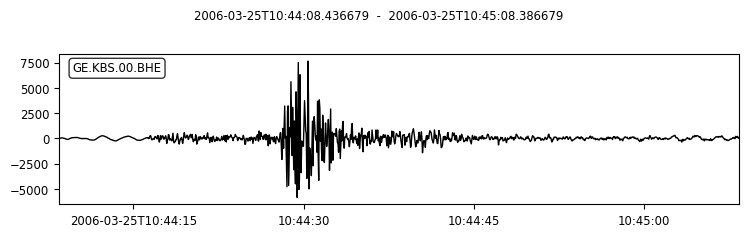

C:\Users\Andras\anaconda3\envs\interdisciplinary_leaflet\lib\site-packages\ipykernel_launcher.py:12: FutureWarning:

Pass orig_sr=20.0, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error



stations_geojson
stations_geojson
stations_geojson
stations_geojson
event selected


C:\Users\Andras\anaconda3\envs\interdisciplinary_leaflet\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



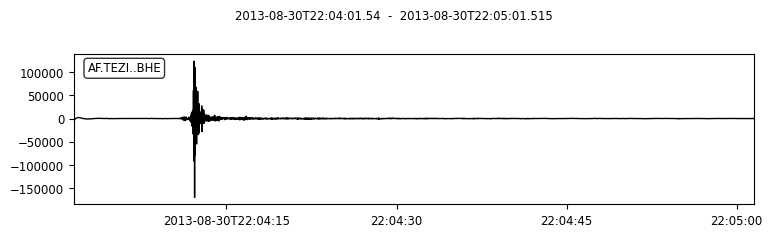

C:\Users\Andras\anaconda3\envs\interdisciplinary_leaflet\lib\site-packages\ipykernel_launcher.py:12: FutureWarning:

Pass orig_sr=40.0, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error



stations_geojson
event selected
data cannot be found
event selected
data cannot be found
event selected
data cannot be found
event selected
data cannot be found


In [109]:
import dash_leaflet as dl
import dash_leaflet.express as dlx
from dash import Dash, html, dcc, Output, Input
from dash_extensions.javascript import assign
import dash_bootstrap_components as dbc
import dash_table
from geopy.geocoders import Nominatim

import base64
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px

import dash_bootstrap_components as dbc
#from dash import  dash_table
import dash_table
from datetime import date
from dash.dependencies import Input,Output,State
from dash import callback_context
from geopy.geocoders import Nominatim
import dash_leaflet as dl
from dash_extensions.javascript import assign

geolocator = Nominatim(user_agent="geoapiExercises")

colorscale = ['red', 'yellow', 'green', 'blue', 'purple']  # rainbow
chroma = "https://cdnjs.cloudflare.com/ajax/libs/chroma-js/2.1.0/chroma.min.js"  # js lib used for colors
color_prop = 'source_magnitude'
colorbar = dl.Colorbar(colorscale=colorscale, width=20, height=150, min=min_magnitude, max=max_magnitude, unit='km')
detail_colorbar = dl.Colorbar(colorscale=colorscale, width=20, height=150,  unit='km', min=min_magnitude, max=max_magnitude, id = 'detail_map_colorbar')
# Geojson rendering logic, must be JavaScript as it is executed in clientside.
point_to_layer = assign("""function(feature, latlng, context){
    const {min, max, colorscale, circleOptions, colorProp} = context.props.hideout;
    const csc = chroma.scale(colorscale).domain([min, max]);  // chroma lib to construct colorscale
    circleOptions.fillColor = csc(feature.properties[colorProp]);  // set color based on color prop.
    return L.circleMarker(latlng, circleOptions);  // sender a simple circle marker.
}""")


point_to_layer_detail_map = assign("""function(feature, latlng, context){
    const {min, max, colorscale, circleOptions, colorProp} = context.props.hideout;
    const csc = chroma.scale(colorscale).domain([min, max]);  // chroma lib to construct colorscale
    circleOptions.fillColor = csc(feature.properties[colorProp]);  // set color based on color prop.
    console.log(min);
    console.log(max);
    console.log(feature.properties);
    console.log(csc(feature.properties[colorProp]));
    return L.circleMarker(latlng, circleOptions);  // sender a simple circle marker.
}""")


#icons/antenna_img.png
# 
# `https://github.com/doromboziandras32/Interdisciplinary/blob/master/icons/antenna_img.png`
draw_antenna = assign("""function(feature, latlng){
const antenna = L.icon({iconUrl: `/static/antenna_img.png`, iconSize: [24,24]});
return L.marker(latlng, {icon: antenna});
}""")


draw_antenna_on_detail_map = assign("""function(feature, latlng){
const antenna = L.icon({iconUrl: `/static/antenna_img.png`, iconSize: [40,40]});
return L.marker(latlng, {icon: antenna});
}""")



#https://fonts.google.com/icons?selected=Material%20Icons%3Asettings_input_antenna%3A

#geojson_filter = assign("function(feature, context){return context.props.hideout.includes(feature.properties.trace_name);}")
#default_available_earthquake_forms = df_test.index.tolist()
app = Dash(external_scripts=[chroma], prevent_initial_callbacks=True)

app.layout = html.Div([dbc.Row([

                                #Filters|
                                html.Div(style={'width':'20%','marginLeft': 5, 'marginRight': 10,'display':'inline-block',"border":"2px black solid",'vertical-align': 'top'},
                                         children = [
                                            #html.Div([
                                            # dcc.Graph: maybe define somehow here?
                                            #dcc.Graph(figure=fig, id='map-layout')]),
                                             #'width':'15%','marginLeft': 20, 'marginRight': 20,
                                            html.Div(style={ 'display': 'block','vertical-align':'middle'},
                                                     children = [
                                                        html.Br(),
                                                        html.H3('Select which providers events and stations would be shown'),
                                                        html.Br(),
                                                    #Datepicker to filter for intervals
                                                         dcc.Dropdown(id='provider-selector', 
                                                            options=[{'label': i, 'value': i} for i in provider_list],
                                                            multi=True, 
                                                            value = provider_list,
                                                            style={},
                                                            className='stockselector',
                                                            clearable=False,
                                                            placeholder = 'Select providers..',
                                                            
                                                            )]), 
                                            html.Div(style={ 'display': 'block','vertical-align':'middle'},
                                                     children = [
                                                        html.Br(),
                                                        html.H3('Select a date interval'),
                                                        html.Br(),
                                                    #Datepicker to filter for intervals
                                                        dcc.DatePickerRange(
                                                            id='date-filter',
                                                            #min_date_allowed=date(1993, 1, 10),
                                                            min_date_allowed=min_date,
                                                            max_date_allowed=max_date,
                                                            #max_date_allowed=date(2019, 9, 19),
                                                            initial_visible_month=min_date,
                                                            start_date=min_date,
                                                            end_date=max_date
                                                        )]),
                                            #'width':'15%','marginLeft': 20, 'marginRight': 20,'marginTop':30,
                                            html.Div(
                                                style={ 'display': 'block','vertical-align':'middle'},
                                                children = [
                                                html.Br(),
                                                html.H3('Select earthquake depth interval ( in km)'),
                                                html.Br(),
                                                #slider to filter for depth
                                                dcc.RangeSlider(min = min_depth, max = max_depth,
                                                                id='depth-slider',
                                                                marks={i: '{:.2f}'.format(i) for i in depth_space},
                                                                value=[min_depth, max_depth],
                                                                dots=False,
                                                                #step=
                                                                step=0.01,
                                                                updatemode='drag',
                                                                tooltip={"placement": "bottom", "always_visible": False}
                                            )]),
                                             #'width':'15%','marginLeft': 20, 'marginRight': 20,'marginTop':30,
                                            html.Div(
                                                style={'display': 'block','vertical-align':'middle'},
                                                children = [
                                                html.Br(),
                                                html.H3('Select earthquake magnitude interval ( in km)'),
                                                html.Br(),
                                                #slider to filter for magnitudes
                                                dcc.RangeSlider(min = min_magnitude, max = max_magnitude,
                                                                id='magnitude-slider',
                                                                marks={i: '{:.2f}'.format(i) for i in magnitude_space},
                                                                value=[min_magnitude, max_magnitude],
                                                                dots=False,
                                                                step=0.01,
                                                                updatemode='drag',
                                                                tooltip={"placement": "bottom", "always_visible": False}
                                                                ),
                                                ]),
                                             html.Div(
                                                 style={'display': 'block','vertical-align':'middle'},
                                                 children = [
                                                             html.Button('Apply Filters', id='filter-apply-btn', n_clicks=0),
                                                             html.Button('Reset Filters', id='filter-reset-btn', n_clicks=0)
                                                             ]
                                             )
                                         ]),
                                #Map
                                html.Div(
                                        style={'width':'75%', 'marginRight': 0.8,'display':'inline-block',"border":"2px black solid"},                                        
                                        children = [dl.Map(children=[
                                                    dl.TileLayer(),
                                                    dl.GeoJSON(data = data_points_geojson,
                                                    #options=dict(filter=geojson_filter), 
                                                    #hideout=default_available_earthquake_forms ,
                                                    options=dict(pointToLayer=point_to_layer),  # how to draw points            
                                                    #options=dict(pointToLayer=point_to_layer_detail_map), 
                                                    #hideout=dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=5),
                                                    hideout=dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=10),
                                                    min=min_magnitude, max=max_magnitude, colorscale=colorscale),                                                    
                                                    cluster=True , zoomToBoundsOnClick=True,
                                                    superClusterOptions={"radius": 100},
                                                    
                                                    id ='earthquake_events_geojson'),
                                                    dl.GeoJSON(data=stations_geojson
                                                                , options=dict(pointToLayer=draw_antenna), zoomToBounds=True,
                                                                clusterToLayer=draw_antenna,
                                                                cluster=True ,  # how to draw clusters
                                                                zoomToBoundsOnClick=True,
                                                                superClusterOptions=dict(radius=150),
                                                                id= 'stations_geojson')  # when true, zooms to bounds of feature (e.g. cluster) on click)
                                                    ,colorbar                                                                
                                                ],
                                                 style={'width': '67%', 'height': '50vh', 'margin': "auto", "display": "inline-block","border-right":"5px black solid"}, id="map"),
                                                 dl.Map(children=[
                                                    dl.TileLayer(),
                                                    dl.GeoJSON(
                                                                #data = dataframe_to_geojson(df_test.head(1)),
                                                                #options=dict(filter=geojson_filter), 
                                                                #hideout=default_available_earthquake_forms ,
                                                                options=dict(pointToLayer=point_to_layer),  # how to draw points            
                                                                #hideout=dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=5),
                                                                hideout=dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=15),
                                                                min=min_magnitude, max=max_magnitude, colorscale=colorscale), 
                                                                zoomToBoundsOnClick=True,
                                                                zoomToBounds=True,                                              
                                                                id ='detail_map_earthquake_geojson'),
                                                    dl.GeoJSON( options=dict(pointToLayer=draw_antenna_on_detail_map),                                                                
                                                                  # how to draw clusters
                                                                zoomToBoundsOnClick=True,                                                                
                                                                id= 'detail_map_stations_geojson'),                                                    
                                                    detail_colorbar
                                                 ]
                                                 ,
                                                 style={'width': '30%', 'height': '50vh', 'margin': "auto", "display": "inline-block"}, id="detail_map")
                                                 ]

                                )]),
                                dbc.Row(html.Div([
                    #Audio player
                    html.Div(style={'width':'40%','marginLeft': 5,'marginTop': 20, 'marginRight': 20,'display':'inline-block',"border":"2px black solid",'vertical-align': 'top'},                            
                           children = [
                                     
                                     html.Audio(html.Source(src=f'/assets/test_raw_waveform_normalized_upsampled.wav',type='audio/wav'), controls=True, id = 'audio_player_main'), 
                                     dash_table.DataTable(id = 'event_info_table',style_header={'display':'none'}
                                      ,style_cell={"whiteSpace": "pre-line"}                                      
                                      ,data = create_event_infos('HPC.NC_20130403221010_EV')
                                      ,style_cell_conditional=[
                                        {'if': {'column_id': 'index'},
                                        'width': '20%'},
                                        {'if': {'column_id': '0'},
                                        'width': '80%'},
                                    ]
                                      ,columns=[{"name": i, "id": i} for i in ['index','0']])
                                      ]),                         
                    html.Div(style={'width':'50%', 'marginRight': 10 ,'marginTop': 20, 'display':'inline-block',"border":"2px black solid"},                             
                             children = [
                                         html.Div(style={ 'display': 'block','vertical-align':'middle'},id = 'seismogram-div',
                                          children = [html.Img(id ='seismogram_img', src = base_seismogram)]),                                        
                                         html.Div(style={ 'display': 'block','vertical-align':'middle'},id = 'spectrogram-div',
                                          children = [html.Img( id ='spectrogram_img',src = spectrogram_plot)])
                                        ])]))
                                ])



@app.callback(
    #Output(component_id='tbl', component_property='data'), #Output will be the table (later map)
    Output(component_id='depth-slider', component_property= 'value'),
    Output(component_id='magnitude-slider', component_property= 'value'),
    Output(component_id='date-filter', component_property= 'start_date'),
    Output(component_id='date-filter', component_property= 'end_date'),
    Output(component_id='earthquake_events_geojson', component_property= 'data'),
    Output(component_id='stations_geojson', component_property= 'data'),
    Output(component_id='map', component_property= 'style'),
    Output(component_id='provider-selector', component_property= 'value'),
    Input(component_id='filter-apply-btn', component_property='n_clicks'), #Input button triggers the callback
    Input(component_id='filter-reset-btn', component_property='n_clicks'), #Input button triggers the callback
    State(component_id='depth-slider', component_property= 'value'),
    State(component_id='magnitude-slider', component_property= 'value'),
    State(component_id='date-filter', component_property= 'start_date'),
    State(component_id='date-filter', component_property= 'end_date'),
    State(component_id='provider-selector', component_property= 'value')    
)

def apply_filter(apply_click,reset_click, depth_value, magnitude_value,start_date,end_date, selected_providers):

    #style_to_refresh={'width': '100%', 'height': '50vh', 'margin': "auto", "display": "block"}
    style_to_refresh={'width': '70%', 'height': '50vh', 'margin': "auto", "display": "inline-block"}
    
    # https://towardsdatascience.com/multi-faceted-data-exploration-in-the-browser-using-leaflet-and-amcharts-f74d049d78d9
    ctx = dash.callback_context
    clicked_element = ctx.triggered[0]['prop_id'].split('.')[0]
    if  clicked_element == 'filter-apply-btn':
        
        provider_filter = stations_df[(stations_df['provider'].isin(selected_providers)) & (stations_df['station_opened'] >= pd.to_datetime(start_date))]


        filtered_stations = list(set(provider_filter['station_id']))
        filter_records = df_test['time'].between(pd.to_datetime(start_date),pd.to_datetime(end_date)) & df_test['source_magnitude'].between(magnitude_value[0],magnitude_value[1])\
                         & df_test['source_depth_km'].between(depth_value[0],depth_value[1]) & df_test['station_id'].isin(filtered_stations)
        df_filtered = df_test[filter_records]

        filtered_datapoints_geojson = dataframe_to_geojson(df_filtered)
        filtered_stations_geojson = stations_df_to_geojson(provider_filter)
        #filtered_wave_names =  df_filtered.index.tolist()

        

        #'earthquake_events_geojson'
        return [depth_value,magnitude_value,start_date,end_date,filtered_datapoints_geojson,filtered_stations_geojson,style_to_refresh,selected_providers]
        #return [df_filtered.head(5).to_dict('records'),depth_value,magnitude_value,start_date,end_date]

    elif clicked_element == 'filter-reset-btn':
        return [[min_depth,max_depth],[min_magnitude,max_magnitude],min_date,max_date,data_points_geojson,stations_geojson,style_to_refresh,provider_list]
       # return [df_test.head(5).to_dict('records'),[min_depth,max_depth],[min_magnitude,max_magnitude],min_date,max_date]

    else:
        return dash.no_update


@app.callback(Output("event_info_table", "data"),
            Output('seismogram_img', 'src'),
            Output('spectrogram_img', 'src'), 
            Output('audio_player_main', 'src'),
            Output('audio_player_main', 'style'),
            Input("earthquake_events_geojson", "click_feature"),
            Input("detail_map_earthquake_geojson", "click_feature"),
            State('seismogram_img', 'src'),
            State('spectrogram_img', 'src'),
            State('audio_player_main', 'style')
)

def select_event(clicked_event,clicked_detail_event, current_seismogram_image, current_spectrogram_image, audi_div_element):

    ctx = dash.callback_context
    clicked_element = ctx.triggered[0]['prop_id'].split('.')[0]
    #print(ctx.triggered[0])
    if clicked_element == "earthquake_events_geojson":
        if ctx.triggered[0]['value'] is not None:
            if ctx.triggered[0]['value']['properties']['cluster'] is True:
                return dash.no_update
            else:
                clicked_event = ctx.triggered[0]['value']
    
    if clicked_element == "detail_map_earthquake_geojson":
        clicked_event = ctx.triggered[0]['value']


    if clicked_event is not None:
    #and clicked_event['properties']['cluster'] is False or clicked_detail_event is not None:
    #    if clicked_event is not None:
    #        event_selection = clicked_event
    #    elif clicked_detail_event is not None:
    #        event_selection = clicked_detail_event

        #Find the corresponding record from metadata
        print('event selected')
        selected_trace_name = clicked_event['properties']['trace_name']
        table_data = create_event_infos(selected_trace_name)
        selected_event = df_test.loc[selected_trace_name]

        
        provider_of_waveform = stations_df[(stations_df['network_name'] == selected_event['network_code']) &  (stations_df['station_name'] == selected_event['receiver_code'])]
        try:
            client = Client(provider_of_waveform['provider'].tolist()[0])

            wave = extract_waveform(client, selected_event)

            spectrogram_plot = spectrogram_to_uri(wave)
            
            #wave.filter("highpass", freq=0.5).spectrogram(log = True)

            #seismic_plot = fig_to_uri(base_seismogram.plot())
            seismic_plot = fig_to_uri(wave.plot())

            #print('seismic sound processing..')
            #create_seismic_sound_to_dash(wave)
            #create_seismic_sound_to_dash_bytes(wave)
            #print('FINISHED')
            audio_src = html.Source(src=create_seismic_sound_to_dash_bytes(wave),type='audio/wav')
            audio_src = create_seismic_sound_to_dash_bytes(wave)
            #audio_player_div_player = html.Audio(children = audio_src, controls=True, id ='seismic_audio_player')
            audio_player_style = {}

            #audio_src = html.Source(src=f'/assets/extracted_seismic_sound.wav',type='audio/wav')
            

        except:
            print('data cannot be found')
            return dash.no_update
            #src = 
                                         #html.Div(style={ 'display': 'block','vertical-align':'middle'},id = 'filtered_seismogram-div', children = [html.Img(src = fig_to_uri(filtered_seismogram.plot()))]),
        #spectrogram_plot =  spectrogram_to_uri(st[2])
        

        return [table_data,seismic_plot,spectrogram_plot,audio_src,audio_player_style]

    else:
        return dash.no_update





@app.callback(
 # how to draw points      
Output(component_id='detail_map_earthquake_geojson', component_property= 'hideout'),
Output(component_id='detail_map_earthquake_geojson', component_property= 'data'),
Output(component_id='detail_map_stations_geojson', component_property= 'data'),
Output(component_id='detail_map', component_property= 'style'),
Output(component_id='detail_map_colorbar', component_property= 'min'),
Output(component_id='detail_map_colorbar', component_property= 'max'),
Output(component_id='detail_map_colorbar', component_property= 'style'),
Input(component_id="stations_geojson",component_property=  "click_feature"),
Input(component_id='filter-apply-btn', component_property='n_clicks'), #Input button triggers the callback
Input(component_id='filter-reset-btn', component_property='n_clicks'), #Input button triggers the callback
State(component_id='depth-slider', component_property= 'value'),
State(component_id='magnitude-slider', component_property= 'value'),
State(component_id='date-filter', component_property= 'start_date'),
State(component_id='date-filter', component_property= 'end_date'),
State(component_id='provider-selector', component_property= 'value') ,
State(component_id='stations_geojson', component_property= 'click_feature'),
 #min=min_magnitude, max=max_magnitude, id = 'detail_map_colorbar'
)

def show_detail_event(clicked_event, apply_click,reset_click, depth_value, magnitude_value,start_date,end_date, selected_providers,last_selected_station):

    style_to_refresh={'width': '30%', 'height': '50vh', 'margin': "auto", "display": "inline-block"}

    ctx = dash.callback_context
    clicked_element = ctx.triggered[0]['prop_id'].split('.')[0]
    if  clicked_element == 'filter-apply-btn':
        print(last_selected_station)
        if last_selected_station is not None and last_selected_station['properties']['cluster'] is False:
            
            selected_station_id = last_selected_station['properties']['station_id']           
        
            station_record = stations_df[stations_df['station_id'] == selected_station_id]         
            filter_records = df_test['time'].between(pd.to_datetime(start_date),pd.to_datetime(end_date)) & df_test['source_magnitude'].between(magnitude_value[0],magnitude_value[1])\
                         & df_test['source_depth_km'].between(depth_value[0],depth_value[1]) & (df_test['station_id'] == selected_station_id)


            df_detail_map_filter  = df_test[filter_records]
            try:
                filtered_data_points_min_magnitude = min(df_detail_map_filter['source_magnitude'])
                filtered_data_points_max_magnitude = max(df_detail_map_filter['source_magnitude'])
            except:
                filtered_data_points_min_magnitude = min_magnitude
                filtered_data_points_max_magnitude = max_magnitude

            hideout_update = dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=10),
                                                        min=filtered_data_points_min_magnitude, max=filtered_data_points_max_magnitude, colorscale=colorscale)
            #print(df_filtered)
            #colorbar = dl.Colorbar(colorscale=colorscale, width=20, height=150, min=min_magnitude, max=max_magnitude, unit='km')

            filtered_datapoints_geojson = dataframe_to_geojson(df_detail_map_filter)
            if len(filtered_datapoints_geojson) == 0:
                filtered_datapoints_geojson = None

            filtered_stations_geojson = stations_df_to_geojson(station_record)
                                    


            return [hideout_update,filtered_datapoints_geojson,filtered_stations_geojson,style_to_refresh,filtered_data_points_min_magnitude,filtered_data_points_max_magnitude,dict()]


        else:
            filtered_data_points_min_magnitude = min_magnitude
            filtered_data_points_max_magnitude = max_magnitude
            hideout_update = dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=10),
                                            min=filtered_data_points_min_magnitude, max=filtered_data_points_max_magnitude, colorscale=colorscale)
        
            return [hideout_update,None,None,style_to_refresh,filtered_data_points_min_magnitude,filtered_data_points_max_magnitude,dict()]

        #filtered_wave_names =  df_filtered.index.tolist()

        

        #'earthquake_events_geojson'
        #return [depth_value,magnitude_value,start_date,end_date,filtered_datapoints_geojson,filtered_stations_geojson,style_to_refresh,selected_providers]
        #return [df_filtered.head(5).to_dict('records'),depth_value,magnitude_value,start_date,end_date]

    elif clicked_element == 'filter-reset-btn':

            filtered_data_points_min_magnitude = min_magnitude
            filtered_data_points_max_magnitude = max_magnitude
            hideout_update = dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=10),
                                            min=filtered_data_points_min_magnitude, max=filtered_data_points_max_magnitude, colorscale=colorscale)
        
            return [hideout_update,None,None,style_to_refresh,filtered_data_points_min_magnitude,filtered_data_points_max_magnitude,dict()]
    
    elif clicked_element == 'stations_geojson':        
        
        if clicked_event is not None and clicked_event['properties']['cluster'] is False:
            style_to_refresh={'width': '30%', 'height': '50vh', 'margin': "auto", "display": "inline-block"}
            selected_station_id = clicked_event['properties']['station_id']
            station_record = stations_df[stations_df['station_id'] == selected_station_id]
            #print(selected_station_id)
            #print(station_record)
            #TODO: trigger hideout
            #TODO: add border to distinguish map and detail map

            #Refresh color property as well, maybe the scales and differences would be shown in more details
            

            filter_records = df_test['time'].between(pd.to_datetime(start_date),pd.to_datetime(end_date)) & df_test['source_magnitude'].between(magnitude_value[0],magnitude_value[1])\
                            & df_test['source_depth_km'].between(depth_value[0],depth_value[1]) & (df_test['station_id'] == selected_station_id)
            #filter_records = df_test['station_id'] == selected_station_id
            df_filtered = df_test[filter_records]
            #print(selected_station_id)
            try:
                filtered_data_points_min_magnitude = min(df_filtered['source_magnitude'])
                filtered_data_points_max_magnitude = max(df_filtered['source_magnitude'])
            except:
                filtered_data_points_min_magnitude = min_magnitude
                filtered_data_points_max_magnitude = max_magnitude

            hideout_update = dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=10),
                                                        min=filtered_data_points_min_magnitude, max=filtered_data_points_max_magnitude, colorscale=colorscale)
            #print(df_filtered)
            #colorbar = dl.Colorbar(colorscale=colorscale, width=20, height=150, min=min_magnitude, max=max_magnitude, unit='km')

            filtered_datapoints_geojson = dataframe_to_geojson(df_filtered)
            if len(filtered_datapoints_geojson) == 0:
                filtered_datapoints_geojson = None
            filtered_stations_geojson = stations_df_to_geojson(station_record)        

            return [hideout_update,filtered_datapoints_geojson,filtered_stations_geojson,style_to_refresh,filtered_data_points_min_magnitude,filtered_data_points_max_magnitude,dict()]

        else:
            return dash.no_update


'''
app.layout = html.Div([
    dl.Map(children=[
        dl.TileLayer(),
        dl.GeoJSON(data=geojson, options=dict(filter=geojson_filter), hideout=dd_defaults, id="geojson", zoomToBounds=True)
    ], style={'width': '100%', 'height': '50vh', 'margin': "auto", "display": "block"}, id="map"),
    dcc.Dropdown(id="dd", value=dd_defaults, options=dd_options, clearable=False, multi=True)
])
'''
# Link drop down to geojson hideout prop (could be done with a normal callback, but clientside is more performant).
#app.clientside_callback("function(x){return x;}", Outp
# ut("geojson", "hideout"), Input("dd", "value"))

if __name__ == '__main__':
    #app.run_server()
    app.run_server(debug=True, use_reloader=False)

In [ ]:
filtered_datapoints_geojson

NameError: name 'filtered_datapoints_geojson' is not defined

In [106]:
df_filtered = df_test[filter_records]

NameError: name 'filter_records' is not defined

Select multiple elements?
#https://github.com/thedirtyfew/dash-leaflet/issues/45

In [ ]:
[s for s in stations if 'KR_FRU1' in s]

['KR_FRU1']

In [ ]:
#set(df_test['station_id'] == 'KR_KDJ')

{False, True}

-0.5

In [ ]:
df_test['time']

trace_name
109C.TA_20060723155859_EV    2006-07-23 15:59:00.960000
109C.TA_20061103155652_EV    2006-11-03 15:56:53.610000
109C.TA_20061103161223_EV    2006-11-03 16:12:24.700000
109C.TA_20061114133221_EV    2006-11-14 13:32:22.540000
109C.TA_20061127104640_EV    2006-11-27 10:46:41.060000
                                        ...            
YHL.WY_20170621094042_EV     2017-06-21 09:40:43.810000
YHL.WY_20170621122104_EV     2017-06-21 12:21:05.390000
YHL.WY_20170621122339_EV     2017-06-21 12:23:40.200000
YHL.WY_20170621133439_EV     2017-06-21 13:34:40.330000
YHL.WY_20170621140610_EV     2017-06-21 14:06:11.750000
Name: time, Length: 1030187, dtype: object